In [1]:
from pymethylprocess.MethylationDataTypes import MethylationArray
from pymethylprocess.general_machine_learning import MachineLearning
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score, roc_curve
import sklearn.metrics as metrics
from sklearn.metrics import auc
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import NearestNeighbors
from sklearn.svm import SVC
import numpy as np
np.random.seed(7)

## Load Data

In [2]:
methyl_array=MethylationArray.from_pickle("my2data/final_preprocessed/methyl_array.pkl")

# make data ready

In [3]:
methyl_array.pheno['disease'] = methyl_array.pheno['disease'].replace('(?i)mucosa|normal|healthy', 0, regex=True)

In [4]:
methyl_array.pheno['disease'] = methyl_array.pheno['disease'].replace('(?i)tumor', 1, regex=True)

In [5]:
methyl_array.pheno['disease'].value_counts()

1    31
0    16
Name: disease, dtype: int64

In [6]:
X=methyl_array.beta
y=pd.DataFrame(methyl_array.pheno['disease'])

# Data augmentation: Increase sample size

In [7]:
df= X.merge(y,left_index=True, right_index = True)

In [8]:
def add_noise(X, y, std_dev):
    noise = np.random.normal(0, std_dev, size=X.shape)
    augmented_X = X + noise
    augmented_data = pd.concat([augmented_X, y], axis=1)
    return augmented_data

In [9]:
def scale_data(X, y, factor):
    augmented_X = X * factor
    augmented_data = pd.concat([augmented_X, y], axis=1)
    return augmented_data

In [10]:
def shuffle_data(X, y):
    augmented_X = X.apply(np.random.permutation)
    augmented_data = pd.concat([augmented_X, y], axis=1)
    return augmented_data

In [11]:
augmented_data0 = add_noise(X, y, 0.1) 
augmented_data1 = scale_data(X, y, 1.2) 
augmented_data2 = shuffle_data(X, y)   
augmented_data3 = add_noise(X, y, 0.4) 

In [12]:
# Concatenate the original data and augmented data
combined_data = pd.concat([df, augmented_data0,augmented_data1,augmented_data2,augmented_data3], ignore_index=True)

In [13]:
X=combined_data.drop("disease",axis=1)
y=combined_data['disease']

# test train split

In [14]:
# split data into training and testing data-sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=7)

In [15]:
y_test.value_counts(),y_train.value_counts()

(1    46
 0    25
 Name: disease, dtype: int64,
 1    109
 0     55
 Name: disease, dtype: int64)

# Cross validation and Building model

In [16]:
# we can add class_weight='balanced' to add panalize mistake
svm_model = SVC(kernel = "linear",class_weight='balanced', probability=True,random_state=47)

In [17]:

# Defining parameter range
param_grid = {
    'C': [0.0005,0.0001,0.01]
}

In [18]:

grid = GridSearchCV(svm_model, param_grid, refit=True, verbose=3)

In [19]:
# Fitting the model for grid search
grid.fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5] END ..........................C=0.0005;, score=0.848 total time=   6.3s
[CV 2/5] END ..........................C=0.0005;, score=0.970 total time=   6.8s
[CV 3/5] END ..........................C=0.0005;, score=0.939 total time=   6.7s
[CV 4/5] END ..........................C=0.0005;, score=0.909 total time=   6.4s
[CV 5/5] END ..........................C=0.0005;, score=0.938 total time=   6.9s
[CV 1/5] END ..........................C=0.0001;, score=0.848 total time=   7.1s
[CV 2/5] END ..........................C=0.0001;, score=0.970 total time=   7.5s
[CV 3/5] END ..........................C=0.0001;, score=0.939 total time=   7.0s
[CV 4/5] END ..........................C=0.0001;, score=0.909 total time=   7.1s
[CV 5/5] END ..........................C=0.0001;, score=0.938 total time=   7.3s
[CV 1/5] END ............................C=0.01;, score=0.848 total time=   5.9s
[CV 2/5] END ............................C=0.01;,

GridSearchCV(estimator=SVC(class_weight='balanced', kernel='linear',
                           probability=True, random_state=47),
             param_grid={'C': [0.0005, 0.0001, 0.01]}, verbose=3)

In [20]:
# print best parameter after tuning
print(grid.best_params_)
  
# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)

{'C': 0.0005}
SVC(C=0.0005, class_weight='balanced', kernel='linear', probability=True,
    random_state=47)


# classification_report

In [21]:
from sklearn.metrics import classification_report, confusion_matrix
grid_predictions = grid.predict(X_test)
print(classification_report(y_test, grid_predictions))

              precision    recall  f1-score   support

           0       0.87      0.80      0.83        25
           1       0.90      0.93      0.91        46

    accuracy                           0.89        71
   macro avg       0.88      0.87      0.87        71
weighted avg       0.89      0.89      0.89        71



# choosing best hyperparameters

In [22]:
model_svm = grid.best_estimator_
model_svm.fit(X_train,y_train)

SVC(C=0.0005, class_weight='balanced', kernel='linear', probability=True,
    random_state=47)

In [23]:
y_proba = model_svm.fit(X_train, y_train).predict_proba(X_test)[:,1]

In [24]:
classes = model_svm.classes_

In [25]:
classes

array([0, 1])

# Feature importance

In [26]:
# for important features:
important_feat = model_svm.coef_[0]
#get indices of those important features
idx = important_feat.argsort(kind= "quicksort")
idx= idx[::-1][:18]

In [27]:
df1 = X.T

In [28]:
top_met = df1.iloc[idx]

In [29]:
top_met.index

Index(['cg25013753', 'cg06634576', 'cg03221390', 'cg10117599', 'cg25203245',
       'cg24396624', 'cg25339566', 'cg22773555', 'cg25587069', 'cg15472092',
       'cg22097731', 'cg13160627', 'cg17840250', 'cg11564601', 'cg26786615',
       'cg04131969', 'cg16956665', 'cg16232979'],
      dtype='object')

# more evaluation metrices:

In [30]:
auc_svm = roc_auc_score(y_test, y_proba)

In [31]:
fpr_svm, tpr_svm, thresholds_svm = roc_curve(y_test, y_proba)


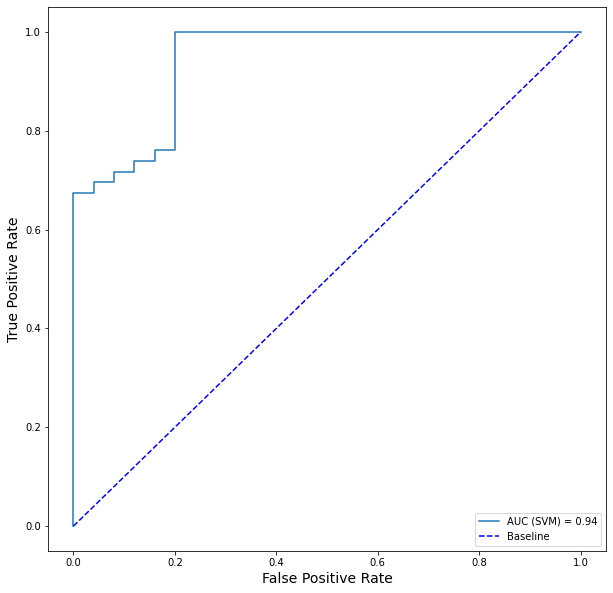

In [32]:
plt.figure(figsize=(10,10))
plt.plot(fpr_svm, tpr_svm, label=f'AUC (SVM) = {auc_svm:.2f}')
plt.plot([0, 1], [0, 1], color='blue', linestyle='--', label='Baseline')
#plt.title('ROC Curve', size=20)
plt.xlabel('False Positive Rate', size=14)
plt.ylabel('True Positive Rate', size=14)
plt.legend();

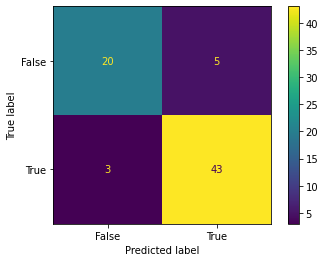

In [33]:
#######CONFUSION MATRIX ###########
from sklearn import metrics
y_test_pred_svm = model_svm.predict(X_test)
confusion_matrix_test = metrics.confusion_matrix(y_test, y_test_pred_svm)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_test, display_labels = [False, True])
cm_display.plot()
plt.show()

In [34]:
total1=sum(sum(confusion_matrix_test))
#####from confusion matrix calculate accuracy
accuracy1=(confusion_matrix_test[0,0]+confusion_matrix_test[1,1])/total1
print ('Accuracy : ', accuracy1)

sensitivity1 = confusion_matrix_test[0,0]/(confusion_matrix_test[0,0]+confusion_matrix_test[0,1])
print('Sensitivity : ', sensitivity1 )

specificity1 = confusion_matrix_test[1,1]/(confusion_matrix_test[1,0]+confusion_matrix_test[1,1])
print('Specificity : ', specificity1)

Accuracy :  0.8873239436619719
Sensitivity :  0.8
Specificity :  0.9347826086956522


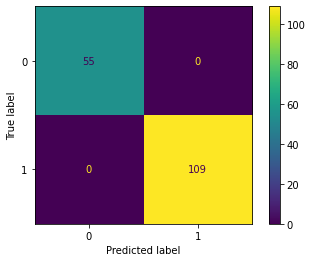

In [35]:
#######CONFUSION MATRIX ###########
y_train_pred_svm = model_svm.predict(X_train)
confusion_matrix_train = metrics.confusion_matrix(y_train, y_train_pred_svm)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_train)
cm_display.plot()
plt.show()

In [36]:
total1=sum(sum(confusion_matrix_train))
#####from confusion matrix calculate accuracy
accuracy1=(confusion_matrix_train[0,0]+confusion_matrix_train[1,1])/total1
print ('Accuracy : ', accuracy1)

sensitivity1 = confusion_matrix_train[0,0]/(confusion_matrix_train[0,0]+confusion_matrix_train[0,1])
print('Sensitivity : ', sensitivity1 )

specificity1 = confusion_matrix_train[1,1]/(confusion_matrix_train[1,0]+confusion_matrix_train[1,1])
print('Specificity : ', specificity1)

Accuracy :  1.0
Sensitivity :  1.0
Specificity :  1.0
